# [**Courbes d'étalonnage de probabilité**](https://nbviewer.org/github/Franck-PepperLabs/pepper_data-science_practising/blob/main/Sklearn/examples/1_16_calibration/plot_calibration_curve.ipynb)<br/>([_Probability Calibration curves_](https://scikit-learn.org/stable/auto_examples/calibration/plot_calibration_curve.html))

Lors de la classification, on souhaite souvent prédire non seulement l'étiquette de classe, mais également la probabilité associée. Cette probabilité donne une sorte de confiance dans la prédiction. Cet exemple montre comment visualiser la qualité de l'étalonnage des probabilités prédites à l'aide de courbes d'étalonnage, également appelées diagrammes de fiabilité. L'étalonnage d'un classifieur non étalonné sera également démontré.

In [1]:
# Author: Alexandre Gramfort <alexandre.gramfort@telecom-paristech.fr>
#         Jan Hendrik Metzen <jhm@informatik.uni-bremen.de>
# License: BSD 3 clause.

# Jeu de données

Nous utiliserons un ensemble de données synthétique de classification binaire comprenant 100 000 échantillons et 20 caractéristiques. Parmi les 20 caractéristiques, seules 2 sont informatives, 10 sont redondantes (combinations aléatoires des caractéristiques informatives) et les 8 restantes ne contiennent aucune information utile (nombres aléatoires). Sur les 100 000 échantillons, 1 000 seront utilisés pour l'apprentissage du modèle et le reste pour les tests.

In [2]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(
    n_samples=100_000, n_features=20, n_informative=2, n_redundant=10, random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.99, random_state=42
)

# Courbes d'étalonnage

## Naive Bayes Gaussien

Tout d'abord, nous allons comparer :
- [**`LogisticRegression`**](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression) (utilisée comme référence, car très souvent, la régression logistique correctement régularisée est bien étalonnée par défaut grâce à l'utilisation de la perte logarithmique)
- [**`GaussianNB`**](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB) non étalonnée
- [**`GaussianNB`**](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB) avec étalonnage isotone et sigmoïde (voir [**Guide de l'utilisateur** (1.16)](https://scikit-learn.org/stable/modules/calibration.html#calibration))

Les courbes d'étalonnage pour ces 4 conditions sont représentées ci-dessous, avec la probabilité prédite moyenne pour chaque bin sur l'axe des x et la fraction de classes positives dans chaque bin sur l'axe des y.

In [3]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

lr = LogisticRegression(C=1.0)
gnb = GaussianNB()
gnb_isotonic = CalibratedClassifierCV(gnb, cv=2, method="isotonic")
gnb_sigmoid = CalibratedClassifierCV(gnb, cv=2, method="sigmoid")

clf_list = [
    (lr, "Logistic"),
    (gnb, "Naive Bayes"),
    (gnb_isotonic, "Naive Bayes + Isotonic"),
    (gnb_sigmoid, "Naive Bayes + Sigmoid"),
]

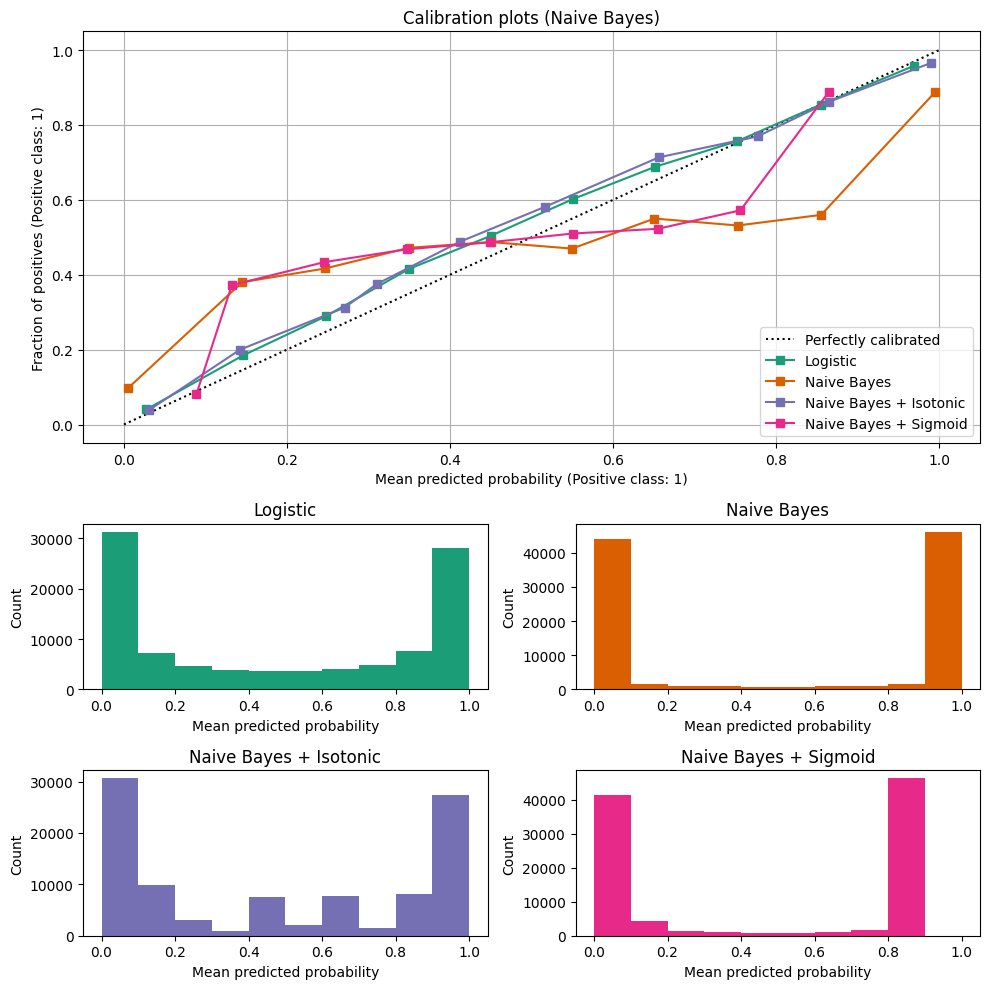

In [4]:
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    display = CalibrationDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots (Naive Bayes)")

# Add histogram
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
for i, (_, name) in enumerate(clf_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()

Le [**`GaussianNB`**](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB) non étalonné est mal étalonné en raison des caractéristiques redondantes qui contreviennent à l'hypothèse d'indépendance des caractéristiques et qui donnent lieu à un classifieur excessivement confiant, comme l'indique la courbe caractéristique typique de la sigmoïde transposée. L'étalonnage des probabilités de [**`GaussianNB`**](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive-bayes.GaussianNB) avec la [**régression isotone** (1.15)](https://scikit-learn.org/stable/modules/isotonic.html#isotonic) peut résoudre ce problème, comme le montre la courbe d'étalonnage presque diagonale. La [**régression sigmoïde** (1.16.3.1)](https://scikit-learn.org/stable/modules/calibration.html#sigmoid-regressor) améliore également légèrement l'étalonnage, bien que pas aussi nettement que la régression non paramétrique isotone. Cela peut s'expliquer par le fait que nous disposons de nombreuses données d'étalonnage, de sorte que la plus grande flexibilité du modèle non paramétrique peut être exploitée.

Nous allons maintenant effectuer une analyse quantitative en tenant compte de plusieurs mesures de classification : [**perte de score Brier** (3.3.2.18)](https://scikit-learn.org/stable/modules/model_evaluation.html#brier-score-loss), [**perte logarithmique** (3.3.2.12)](https://scikit-learn.org/stable/modules/model_evaluation.html#log-loss), [**précision, rappel, score F1** (3.3.2.9)](https://scikit-learn.org/stable/modules/model_evaluation.html#precision-recall-f-measure-metrics) et [**AUC ROC** (3.3.2.15)](https://scikit-learn.org/stable/modules/model_evaluation.html#roc-metrics).

In [5]:
from collections import defaultdict

import pandas as pd

from sklearn.metrics import (
    brier_score_loss,
    f1_score,
    log_loss,
    precision_score,
    recall_score,
    roc_auc_score,
)

scores = defaultdict(list)
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    y_prob = clf.predict_proba(X_test)
    y_pred = clf.predict(X_test)
    scores["Classifier"].append(name)

    for metric in [brier_score_loss, log_loss, roc_auc_score]:
        score_name = metric.__name__.replace("_", " ").replace("score", "").capitalize()
        scores[score_name].append(metric(y_test, y_prob[:, 1]))

    for metric in [precision_score, recall_score, f1_score]:
        score_name = metric.__name__.replace("_", " ").replace("score", "").capitalize()
        scores[score_name].append(metric(y_test, y_pred))

    score_df = pd.DataFrame(scores).set_index("Classifier")
    score_df.round(decimals=3)

score_df

,Brier loss,Log loss,Roc auc,Precision,Recall,F1
Classifier,,,,,,
Logistic,0.098921,0.323178,0.937457,0.872009,0.851408,0.861586
Naive Bayes,0.117608,0.782755,0.940374,0.857400,0.875941,0.866571
Naive Bayes + Isotonic,0.098332,0.370738,0.938613,0.883065,0.836224,0.859007
Naive Bayes + Sigmoid,0.108880,0.368896,0.940201,0.861106,0.871277,0.866161


Remarquez que bien que l'étalonnage améliore la [**perte de score Brier** (3.3.2.18)](https://scikit-learn.org/stable/modules/model_evaluation.html#brier-score-loss) (une métrique composée d'un terme d'étalonnage et d'un terme de raffinement) et la [**perte logarithmique** (3.3.2.12)](https://scikit-learn.org/stable/modules/model_evaluation.html#log-loss), il n'altère pas significativement les mesures de précision, de rappel et de score F1 de la prédiction. Cela est dû au fait que l'étalonnage ne devrait pas modifier de manière significative les probabilités de prédiction au niveau du seuil de décision (à x = 0,5 sur le graphique). L'étalonnage devrait cependant rendre les probabilités prédites plus précises et donc plus utiles pour prendre des décisions d'allocation en cas d'incertitude. De plus, l'AUC ROC ne devrait pas du tout changer car l'étalonnage est une transformation monotone. En effet, aucune métrique de classement n'est affectée par l'étalonnage.

### Classifieur à vecteurs de support linéaires

Ensuite, nous allons comparer :
- [**`LogisticRegression`**](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression) (baseline)
- [**`LinearSVC`**](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC) non étalonné. Étant donné que SVC ne produit pas de probabilités par défaut, nous mettons naïvement à l'échelle la sortie de la [**`decision_function`**](https://scikit-learn.org/stable/glossary.html#term-decision_function) dans l'intervalle $[0, 1]$ en appliquant une mise à l'échelle min-max.
- [**`LinearSVC`**](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC) avec étalonnage isotone et sigmoïde (voir [**Guide de l'utilisateur** (1.16)](https://scikit-learn.org/stable/modules/calibration.html#calibration)).

In [6]:
import numpy as np

from sklearn.svm import LinearSVC


class NaivelyCalibratedLinearSVC(LinearSVC):
    """LinearSVC with `predict_proba` method that naively scales
    `decision_function` output for binary classification."""

    def fit(self, X, y):
        super().fit(X, y)
        df = self.decision_function(X)
        self.df_min_ = df.min()
        self.df_max_ = df.max()

    def predict_proba(self, X):
        """Min-max scale output of `decision_function` to [0, 1]."""
        df = self.decision_function(X)
        calibrated_df = (df - self.df_min_) / (self.df_max_ - self.df_min_)
        proba_pos_class = np.clip(calibrated_df, 0, 1)
        proba_neg_class = 1 - proba_pos_class
        return np.c_[proba_neg_class, proba_pos_class]

In [7]:
lr = LogisticRegression(C=1.0)
svc = NaivelyCalibratedLinearSVC(max_iter=10_000, dual="auto")
svc_isotonic = CalibratedClassifierCV(svc, cv=2, method="isotonic")
svc_sigmoid = CalibratedClassifierCV(svc, cv=2, method="sigmoid")

clf_list = [
    (lr, "Logistic"),
    (svc, "SVC"),
    (svc_isotonic, "SVC + Isotonic"),
    (svc_sigmoid, "SVC + Sigmoid"),
]

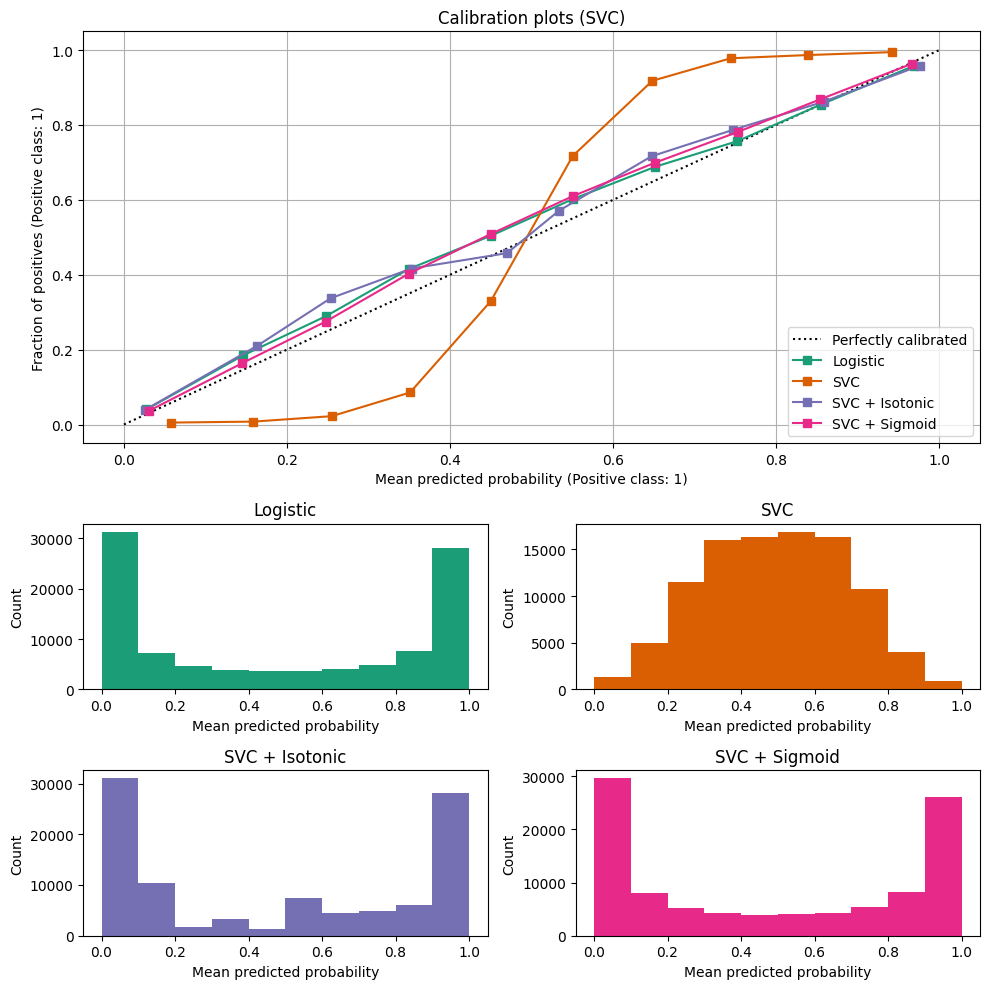

In [8]:
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    display = CalibrationDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots (SVC)")

# Add histogram
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
for i, (_, name) in enumerate(clf_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()

[**`LinearSVC`**](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC) présente un comportement opposé à celui de [**`GaussianNB`**](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB) ; la courbe d'étalonnage a une forme sigmoïde, ce qui est typique d'un classifieur peu confiant. Dans le cas de [**`LinearSVC`**](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC), cela est dû à la propriété de marge de la perte de charnière, qui se concentre sur les échantillons proches de la frontière de décision (vecteurs de support). Les échantillons éloignés de la frontière de décision n'ont pas d'impact sur la perte de charnière. Il est donc logique que [**`LinearSVC`**](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC) ne tente pas de séparer les échantillons dans les régions de haute confiance. Cela se traduit par des courbes d'étalonnage plus plates près de 0 et 1, comme le montrent des observations empiriques avec divers ensembles de données dans Niculescu-Mizil & Caruana [1].

Les deux types d'étalonnage (sigmoïde et isotone) peuvent résoudre ce problème et donner des résultats similaires.

Comme précédemment, nous présentons le [**Brier score loss** (3.3.2.18)](https://scikit-learn.org/stable/modules/model_evaluation.html#brier-score-loss), la [**log loss** (3.3.2.12)](https://scikit-learn.org/stable/modules/model_evaluation.html#log-loss), la [**précision, le rappel, le score F1** (3.3.2.9)](https://scikit-learn.org/stable/modules/model_evaluation.html#precision-recall-f-measure-metrics) et l'[**aire sous la courbe ROC (AUC ROC)** (3.3.2.15)](https://scikit-learn.org/stable/modules/model_evaluation.html#roc-metrics).

In [9]:
scores = defaultdict(list)
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    y_prob = clf.predict_proba(X_test)
    y_pred = clf.predict(X_test)
    scores["Classifier"].append(name)

    for metric in [brier_score_loss, log_loss, roc_auc_score]:
        score_name = metric.__name__.replace("_", " ").replace("score", "").capitalize()
        scores[score_name].append(metric(y_test, y_prob[:, 1]))

    for metric in [precision_score, recall_score, f1_score]:
        score_name = metric.__name__.replace("_", " ").replace("score", "").capitalize()
        scores[score_name].append(metric(y_test, y_pred))

    score_df = pd.DataFrame(scores).set_index("Classifier")
    score_df.round(decimals=3)

score_df

,Brier loss,Log loss,Roc auc,Precision,Recall,F1
Classifier,,,,,,
Logistic,0.098921,0.323178,0.937457,0.872009,0.851408,0.861586
SVC,0.144943,0.465660,0.937597,0.872186,0.851792,0.861868
SVC + Isotonic,0.099820,0.376999,0.936480,0.853174,0.877981,0.865400
SVC + Sigmoid,0.098758,0.321301,0.937532,0.873724,0.848743,0.861053


Tout comme pour [**`GaussianNB`**](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB) ci-dessus, l'étalonnage améliore à la fois le [**Brier score loss** (3.3.2.18)](https://scikit-learn.org/stable/modules/model_evaluation.html#brier-score-loss) et la [**log loss** (3.3.2.12)](https://scikit-learn.org/stable/modules/model_evaluation.html#log-loss), mais n'altère pas beaucoup les mesures de précision des prédictions ([**précision, rappel, score F1** (3.3.2.9)](https://scikit-learn.org/stable/modules/model_evaluation.html#precision-recall-f-measure-metrics)).

# Résumé

L'étalonnage sigmoïde paramétrique peut traiter les situations où la courbe d'étalonnage du classifieur de base est sigmoïde (par exemple, pour [**`LinearSVC`**](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC)), mais pas lorsqu'elle est transposée-sigmoïde (par exemple, [**`GaussianNB`**](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive-bayes.GaussianNB)). L'étalonnage isotone non paramétrique peut gérer les deux situations, mais peut nécessiter davantage de données pour produire de bons résultats.

# References

🔬 [1] [**“Predicting Good Probabilities With Supervised Learning”**](https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.60.7135&rep=rep1&type=pdf), A. Niculescu-Mizil & R. Caruana, ICML 2005